In [163]:
import numpy as np
from qutip import tensor, basis, ket2dm, average_gate_fidelity, Qobj
from qutip_qip.circuit import QubitCircuit
from chalmers_qubit.sarimner import (
    SarimnerProcessor, SarimnerModel, SarimnerCompiler, DecoherenceNoise
)
from chalmers_qubit.base.operations import project_on_qubit

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Single Qubit Gate Example
We begin by creating a quantum circuit that has two qubits, and we independently perform two single-qubit gates on them

In [164]:
num_qubits = 1
circuit = QubitCircuit(num_qubits)

circuit.add_gate("RX", targets=0, arg_value=np.pi)
circuit.add_gate("RY", targets=0, arg_value=np.pi/2)

Next we define the hardware parameters that we will use when simulating this quantum circtuit. We therefore define a dictionary where the `key` corresponds to the qubit index and the value is another `dict` that can have the following values:
- `frequency`: Qubit frequency in GHz.
- `anharmonicity`: Qubit anharmonicity in GHz.
- `rotating frame frequency`: (Optional) Rotating frame frequency in GHz. If excluded the simulation will use the qubit frequency as the rotating frame frequency.

- `t1`: List with relaxation times $T_1$ for each qubit in nano seconds.
- `t2`: List with pure dephasing times $T_2$ for each qubit in nano seconds.

In [165]:
transmon_dict = {
    0: {"frequency": 5.0, "anharmonicity": -0.30},
}
decoherence_dict = {
    0: {"t1": 60e3, "t2": 100e3},
}

Next we take these hardware parameters that we have defined and we load them onto our superconducting hardware model `SarimnerModel`. This along with the `compiler` and `noise` is given to `SarimnerProcessor`.

In [166]:
# Load the physical parameters onto the model
model = SarimnerModel(transmon_dict=transmon_dict)

# Choose compiler
compiler = SarimnerCompiler(model=model)

In [167]:
# Add noise
noise = [DecoherenceNoise(decoherence_dict=decoherence_dict)]

# Create the processor with the given hardware parameters
sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=noise)

Once we have defined our processor we can load the quantum circuit onto the processor. This will compile the circuit into a pulse sequence.

In [168]:
tlist, coeffs = sarimner.load_circuit(circuit)

We can choose to plot the pulse sequence

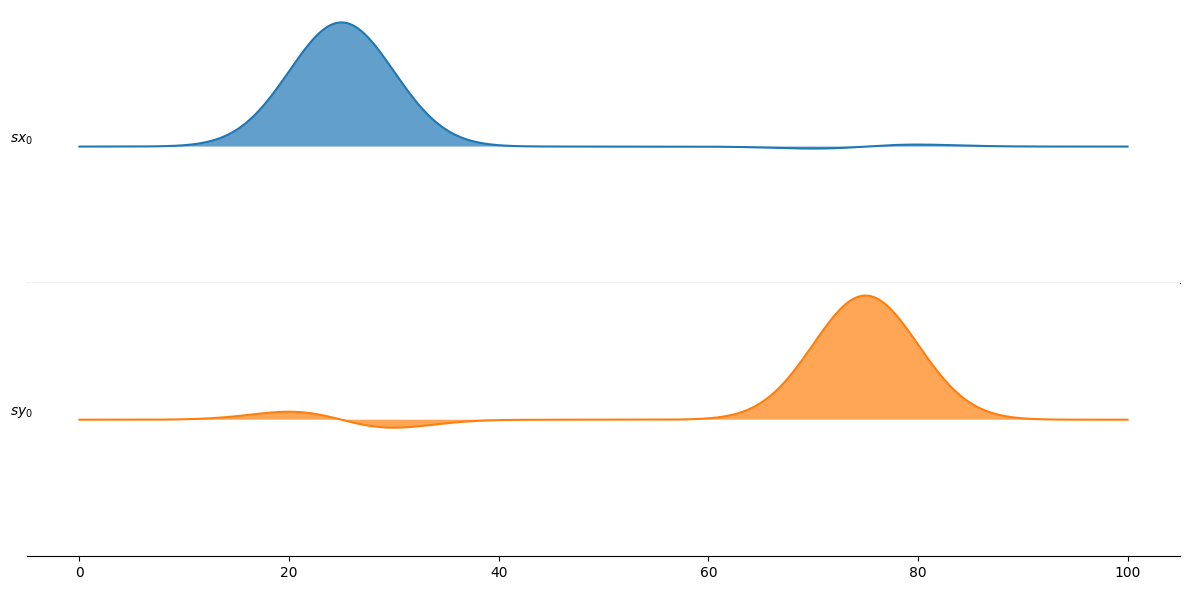

In [169]:
fig, ax = sarimner.plot_pulses(show_axis=True);

Now we can exectue this pulse sequence on the processor by using `run_state` with a given `initial state`

In [170]:
initial_state = basis(3,0)
result = sarimner.run_state(initial_state)
final_state = result.states[-1]
final_state

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.49976991+4.74286926e-17j -0.49904301+2.07735778e-03j]
 [-0.49904301-2.07735778e-03j  0.5002299 -5.06386269e-17j]]

Since we simulated the system for a three-level system we have to project it onto the computational subspace using the function `project_on_qubit`

In [171]:
project_on_qubit(final_state)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.49976991+4.74286926e-17j -0.49904301+2.07735778e-03j]
 [-0.49904301-2.07735778e-03j  0.5002299 -5.06386269e-17j]]

# Two Qubit Gate Example

Next we show a simple circuit using a two-qubit `CZ`-gate and how to compile it onto our processor.

In [172]:
# Define a circuit and run the simulation
num_qubits = 2
circuit = QubitCircuit(num_qubits)
circuit.add_gate("ISWAP", controls=0, targets=1)

Just as before we start by defining our hardware parameters. Additionally we need to supply information of how the qubits are coupled together. This is done using another dictionary, where the value is supplied as a tuple `(i,j)` defining qubit $i$ and qubit $j$ and the value is the coupling strength in GHz.

In [173]:
transmon_dict = {
    0: {"frequency": 5.0, "anharmonicity": -0.30},
    1: {"frequency": 5.4, "anharmonicity": -0.30},
}
# Times in (ns)
t = 100

# corresponding coupling
g = 1 / (np.sqrt(2) * t)

coupling_dict = {
    (0, 1): g,
}
decoherence_dict = {
    0: {"t1": 60e3, "t2": 80e3},
    1: {"t1": 100e3, "t2": 105e3},
}

and load them onto our model

In [188]:
# Load the physical parameters onto the model
model = SarimnerModel(transmon_dict=transmon_dict, coupling_dict=coupling_dict)
# Options for compiler
options = {
    "dt": 0.1,
    "two_qubit_gate": {
        "buffer_time": 0,
        "rise_fall_time": 0,
    },
}
# Choose compiler
compiler = SarimnerCompiler(model=model, options=options)
# Create the processor with the given hardware parameters
sarimner = SarimnerProcessor(model=model, compiler=compiler)

then we can compile the circuit onto our processor

In [189]:
tlist, coeffs = sarimner.load_circuit(circuit)

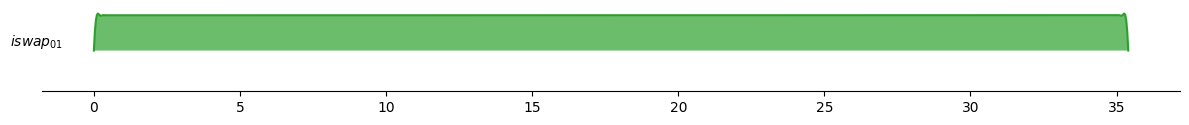

In [190]:
sarimner.plot_pulses(show_axis=True);

To see that the CZ-gate is implemented correctly we will now simulate the circuit using the master equation simulation and look at the expectation values of the $|11\rangle$ and $|20\rangle$ states.

In [191]:
ket01 = tensor(basis(3,0), basis(3,1))
ket10 = tensor(basis(3,1), basis(3,0))
ket11 = tensor(basis(3,1), basis(3,1))
ket20 = tensor(basis(3,2), basis(3,0))
# List of operators we wanna compute the expectation value for during the simulation
e_ops = [ket2dm(ket01), ket2dm(ket10), ket2dm(ket11), ket2dm(ket20)]
result = sarimner.run_state(ket01, e_ops=e_ops, options={'nsteps': 1e5, 'store_final_state': True})

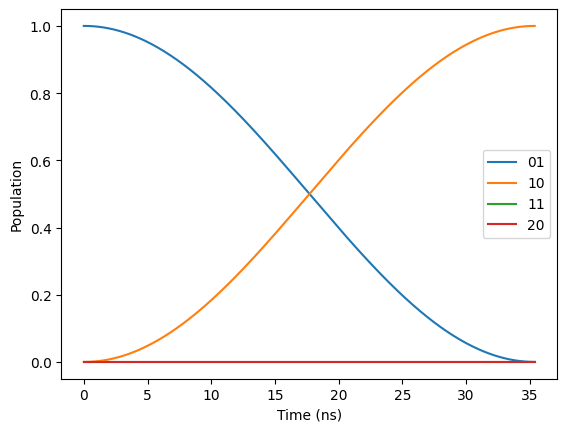

In [192]:
import matplotlib.pyplot as plt
plt.plot(result.times, result.expect[0], label="01")
plt.plot(result.times, result.expect[1], label="10")
plt.plot(result.times, result.expect[2], label='11')
plt.plot(result.times, result.expect[3], label='20')
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.legend()

And if we print the final state we see that the $|11\rangle$ state has the desired $-1$ phase.

In [193]:
qubit_state = project_on_qubit(result.final_state)
qubit_state

Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.        +0.j        ]
 [0.00103703+0.j        ]
 [0.        -0.99999946j]
 [0.        +0.j        ]]

## Three Qubit Gate Example

Finally we will demonstrate the implementation of the three-qubit gate.

Since this gate is not part of qutip `QubitCircuit` we have to defined the gate ourself and supply as `user_gates`

In [187]:
from qutip import Qobj
# Ideal gate
def cczs(args):
    theta, phi, gamma = args
    U = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, -np.exp(-1j*gamma)*np.sin(theta/2)**2 + np.cos(theta/2)**2, 
                                    (1/2)*(1 + np.exp(-1j*gamma))*np.exp(-1j*phi)*np.sin(theta), 0],
                  [0, 0, 0, 0, 0, (1/2)*(1 + np.exp(-1j*gamma))*np.exp(1j*phi)*np.sin(theta), 
                                    -np.exp(-1j*gamma)*np.cos(theta/2)**2 + np.sin(theta/2)**2, 0],
                  [0, 0, 0, 0, 0, 0, 0, -np.exp(1j*gamma)]], dtype="complex")
    return Qobj(U, dims=[[2]*3, [2]*3])

In [66]:
# Define a circuit and run the simulation
num_qubits = 3

circuit = QubitCircuit(num_qubits)
circuit.user_gates = {"CCZS": cczs}
circuit.add_gate("CCZS", targets=[0,1,2], arg_value=[np.pi/2,0,0])

In [93]:
transmon_dict = {
            0: {"frequency": 5.0, "anharmonicity": 0.3},
            1: {"frequency": 5.4, "anharmonicity": 0.3},
            2: {"frequency": 5.2, "anharmonicity": 0.3},
        }

# Times in (ns)
t = 20

# corresponding coupling
g = 1 / (np.sqrt(2) * t)

coupling_dict = {(0, 1): g,
                 (0, 2): -g}

0.029619219587722442


In [110]:
# Load the physical parameters onto the model
model = SarimnerModel(
    transmon_dict=transmon_dict,
    coupling_dict=coupling_dict
)
options = {
    "dt": 0.1,
    "two_qubit_gate": {
        "buffer_time": 0,
        "rise_fall_time": 0.1,
    },
}
# Choose compiler
compiler = SarimnerCompiler(model=model, options=options)
# Create the processor with the given hardware parameters
sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=[])

In [111]:
tlist, coeffs = sarimner.load_circuit(circuit)

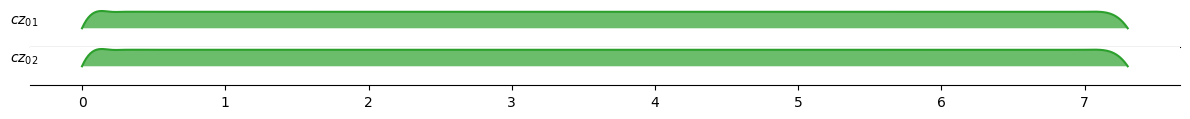

In [112]:
sarimner.plot_pulses(show_axis=True);

In [113]:
ket110 = tensor([basis(3,1),basis(3,1),basis(3,0)])
ket101 = tensor([basis(3,1),basis(3,0),basis(3,1)])
ket200 = tensor([basis(3,2),basis(3,0),basis(3,0)])
e_ops = [ket2dm(ket110), ket2dm(ket101), ket2dm(ket200)]
result = sarimner.run_state(ket110, e_ops=e_ops, options={'store_states':True, 'nsteps':1e5, 'atol': 1e-12})

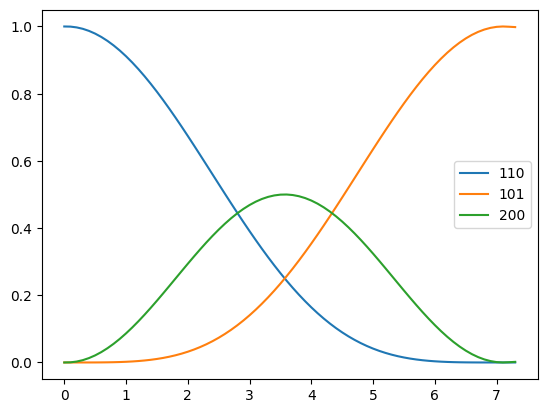

In [114]:
import matplotlib.pyplot as plt
plt.plot(result.times,result.expect[0], label="110")
plt.plot(result.times,result.expect[1], label="101")
plt.plot(result.times,result.expect[2], label="200")
plt.legend()

In [115]:
prop = sarimner.run_propagator(options={"nsteps":1e5})
prop = project_on_qubit(prop)
prop

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   1.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e

In [116]:
ideal_prop = cczs((np.pi/2,0,0))

In [117]:
average_gate_fidelity(ideal_prop, prop)

0.9991841564697082